In [1]:
import sys
# Append the previous directory to the path
sys.path.append('../')

In [2]:
import json
import numpy as np
import pandas as pd

from counterplots import CreatePlot
import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split

dataset = helpers.load_adult_income_dataset()
target = dataset["income"] # outcome variable
train_dataset, test_dataset, _, _ = train_test_split(dataset,
                                                     target,
                                                     test_size=0.2,
                                                     random_state=0,
                                                     stratify=target)
# Dataset for training an ML model
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=['age', 'hours_per_week'],
                 outcome_name='income')

# Pre-trained ML model
m = dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(),
                  backend='TF2', func="ohe-min-max")


2023-05-08 14:31:16.505557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 14:31:17.458248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2023-05-08 14:31:17.458503: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2023-05-08 14:31:17.458514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:3

In [3]:
# DiCE explanation instance
exp = Dice(d,m)

2023-05-08 14:31:18.096106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 14:31:18.105215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 14:31:18.105537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 14:31:18.106163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [4]:
def dice_counterplots(dice_exp, exp):
    
    cf_data = json.loads(dice_exp.to_json())
    factual = cf_data['test_data'][0][0][:-1]
    feature_names = exp.data_interface.feature_names
    df_structure = exp.data_interface.data_df[:0].loc[:, feature_names]
    data_types = df_structure.dtypes.apply(lambda x: x.name).to_dict()
    
    def adjust_types(x):
        for i in range(x.shape[1]):
            if 'int' in list(data_types.values())[i]:
                x[:, i] = int(float(x[:, i]))
        return x
    
    def model_pred(x):
        scores = exp.predict_fn(df_structure.append(pd.DataFrame(x, columns=feature_names))).numpy()
        return np.concatenate((1 - scores, scores), axis=1)
    
    out_exp = []
    
    for raw_cf in cf_data['cfs_list'][0]:
        cf = adjust_types(np.array([raw_cf[:-1]]))[0]
    
        out_exp.append(CreatePlot(
            factual=np.array(factual),
            cf=np.array(cf),
            model_pred=model_pred,
            feature_names=feature_names,
            class_names={0: 'Less than 50k', 1: 'More than 50k'}))
    
    return out_exp

In [5]:
# Disable pandas warnings
import warnings
warnings.filterwarnings("ignore")

for i in range(200):
    found_list = []
    query_instance = test_dataset.drop(columns="income")[i:i+1]
    dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")

    ctps = dice_counterplots(dice_exp, exp)
    
    if len(ctps[0].countershapley_values()['feature_values']) > 2:
        if ctps[0].factual_score + sum(sorted(ctps[0].countershapley_values()['feature_values'])[::-1][:-1]) > 0.5:
            break

100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


In [6]:
ctps[0].countershapley_values()

{'feature_names': ['education', 'age', 'marital_status'],
 'feature_values': (0.2760162949562073,
  0.2713109701871872,
  0.08044150906304519),
 'feature_indices': (2, 0, 3)}

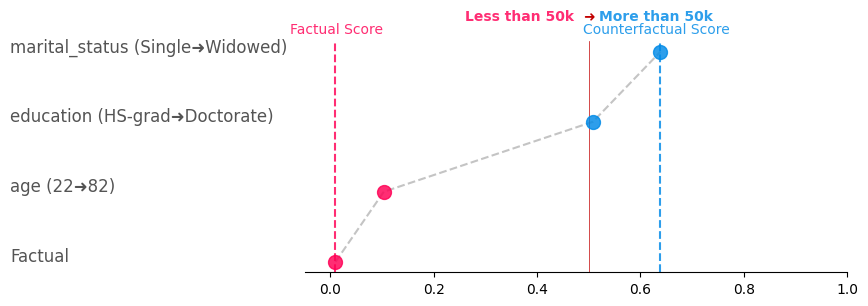

In [7]:
ctps[0].greedy()

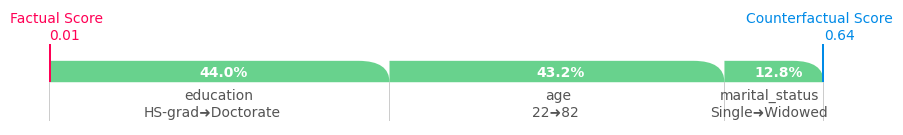

In [8]:
ctps[0].countershapley()

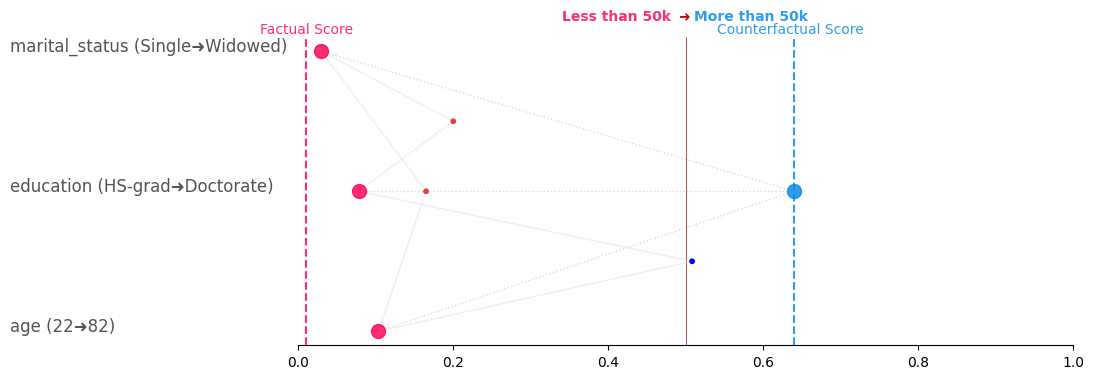

In [9]:
ctps[0].constellation()